# Nested cross-validation

In this notebook, we show a pattern called **nested cross-validation** which
should be used when you want to **both evaluate a model and tune the
model's hyperparameters**.

**Cross-validation** is a powerful tool to **evaluate the statistical performance
of a model**. It is also used to **select the best model from a pool of models**.
This pool of models can be the same **family of predictors with different
parameters**. In this case, we call this procedure **hyperparameter tuning**.

We could also imagine that we would like to **choose among heterogeneous models
that will similarly use the cross-validation**.

Before we go into details regarding the nested cross-validation, we will
first recall the pattern used to **fine tune a model's hyperparameters**.

Let's load the **breast cancer dataset**.

In [1]:
from sklearn.datasets import load_breast_cancer

data, target = load_breast_cancer(return_X_y=True)

Now, we'll make a minimal example using the utility **`GridSearchCV`** to **find
the best parameters via cross-validation**.

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {"C": [0.1, 1, 10], "gamma": [.01, .1]}
model_to_tune = SVC()

search = GridSearchCV(estimator=model_to_tune, param_grid=param_grid,
                      n_jobs=-1)
search.fit(data, target)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1]})

We recall that `GridSearchCV` will **train a model** with some **specific parameter**
**on a training set and evaluate it on the test set**. However, **this evaluation is
done via cross-validation** using the `cv` parameter. This procedure is
repeated for all possible combinations of parameters given in `param_grid`.

The attribute **`best_params_`** will give us the **best set of parameters** that
maximize the mean score on the internal test sets.

In [3]:
print(f"The best parameter found are: {search.best_params_}")

The best parameter found are: {'C': 0.1, 'gamma': 0.01}


We can now show the mean score obtained using the parameter `best_score_`.

In [4]:
print(f"The mean score in CV is: {search.best_score_:.3f}")

The mean score in CV is: 0.627


At this stage, one should be extremely careful using this score. The
misinterpretation would be the following: since the score was computed on a
test set, it could be considered our model's test score.

However, we should not forget that we used this score to pick out the best
model. It means that **we used knowledge from the test set (i.e. test score) to
decide our model's training parameter**.

Thus, **this score** is not a reasonable estimate of our test error.
Indeed, we can show that it is **too optimistic** in practice. **The good way
is to use a "nested" cross-validation**. We will use an **inner cross-validation
corresponding to the previous procedure** shown **to optimize the
hyperparameters**. We will also include this procedure within an **outer
cross-validation**, which will be used **to estimate the testing error of
our tuned model**.

In this case, our inner cross-validation will always get the training set of
the outer cross-validation, making it possible to compute the test
score on a completely independent set.

We will show below how we can **create such nested cross-validation** and obtain
the **true test score**.

In [5]:
from sklearn.model_selection import cross_val_score, KFold

# Declare the inner and outer cross-validation
inner_cv = KFold(n_splits=4, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=0)

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=-1)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=-1)
print(f"The mean score using nested cross-validation is: "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

The mean score using nested cross-validation is: 0.627 +/- 0.021


In the example above, the reported score can be trusted moer and should be close
to the expected statistical performance in production.

We will **illustrate the difference between the nested and non-nested
cross-validation scores** to show that the **latter** one will be **too optimistic** in
practice. In this regard, we will repeat the experiment several times and
shuffle the data differently. Besides, we will store the scores obtained with
and without the nested cross-validation.

In [6]:
test_score_not_nested = []
test_score_nested = []

N_TRIALS = 20
for i in range(N_TRIALS):
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    model = GridSearchCV(estimator=model_to_tune, param_grid=param_grid,
                         cv=inner_cv, n_jobs=-1)

    # Non_nested parameter search and scoring
    model.fit(data, target)
    test_score_not_nested.append(model.best_score_)

    # Nested CV with parameter optimization
    test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=-1)
    test_score_nested.append(test_score.mean())

We can merge the data together and make a **box plot of the two strategies**.

In [7]:
import pandas as pd

all_scores = {
    "Not nested CV": test_score_not_nested,
    "Nested CV": test_score_nested,
}
all_scores = pd.DataFrame(all_scores)

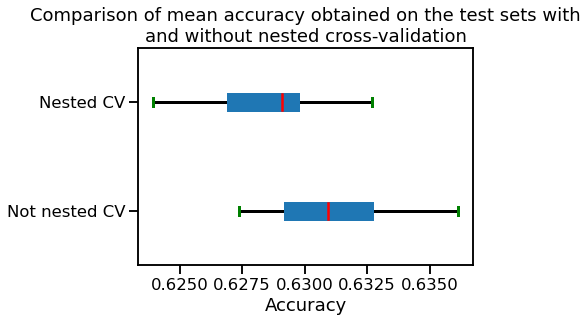

In [9]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "red", "caps": "green"}
all_scores.plot.box(color=color, vert=False)
plt.xlabel("Accuracy")
_ = plt.title("Comparison of mean accuracy obtained on the test sets with\n"
              "and without nested cross-validation")

We observe that the model's **statistical performance with the nested
cross-validation is not as good as the non-nested cross-validation**.

As a conclusion, when optimizing parts of the machine learning pipeline (e.g.
hyperparameter, transform, etc.), one needs to use nested cross-validation to
evaluate the statistical performance of the predictive model. Otherwise, the
results obtained without nested cross-validation are over-optimistic.